In [114]:
import pandas 
import math
import matplotlib.pyplot as plt

In [116]:
read_company_DS = pandas.read_csv('company_directorships.csv')
read_company_DS['software_background'] = read_company_DS['software_background'].eq('t')  # 't' means boolean 'True' 
read_company_DS.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
4427,FIRST COMMONWEALTH FINANCIAL CORP /PA/,712537,JON L. GORNEY,True,2013-03-22,2025-03-13
12183,U-Haul Holding Co /NV/,4457,M. FRANK LYONS,False,2002-07-26,2012-07-18
3509,DIXIE GROUP INC,29332,"D. KENNEDY FRIERSON, JR.",False,2013-03-25,2025-04-08
11262,SUNLINK HEALTH SYSTEMS INC,96793,BYRON D. FINN,False,2023-09-27,2023-09-27
10724,SMITH A O CORP,91142,GENE C. WULF,True,2014-03-07,2022-03-03


Fix 1:
Renamed 'df' to 'read_company_DS' to make it clear. 'df' was too ambiguous and this change improves readability.

Fix 2:
't' was ambiguous and wasn't clear on what it meant. We have now clarified that 't' indicates 'True' supported by a inline comment, and we have removed the use of the lambda.

In [119]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    return mode_values[0] if not mode_values.empty else None # return the mode from a series, or None if not found.

    
grouped = compensation_and_demographics_raw.groupby('NAME') # removed redundant .groupby calls
compensation_and_demographics = pandas.DataFrame({
    'age': grouped.age.max(),
    'compensation': grouped.compensation.sum(),
    'gender': grouped.gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


Fix 3:
The .groupby('NAME') was called 3 times. Changing the groupby call into a variable avoids repetition and keeps the code clean.

Fix 4: Simplified and clarified the most common function, with simpler code and inline comment saying what it does. We used .empty instead of len() > 0 making it more readable/easier to understand.

Task 3:
The 'role' column in 'director-details.csv' describes each director's official title or position, such as "CEO", "Board Member", or "Executive Vice President".
The data has been loaded but is unused in the analysis.

This feature is useful for distinguishing between executive and non-executive directors.
Certain roles (e.g., CEOs) may be more important in board decisions, resulting in a greater impact on potential acquisitions.
We could compare centrality ratings by role e.g., do CEOs have stronger eigenvector or betweenness centrality than CFOs?

This feature could provide context for network analysis by linking influence scores to organisational power or responsibility.

Task 4: - ASX Listed companies
Dataset source: https://www.asxlistedcompanies.com/

Why this is useful:
It helps differentiate between small and large enterprises.
- We can determine whether directors are more likely to serve on the boards of larger organisations or certain industries.
- It helps acquisition targeting by identifying businesses that are both well-connected and properly sized.

How would it be integrated?
We would combine this dataset with 'company_directorships.csv', using the 'company_name' column as a common key (after some cleanup). This would enable us to incorporate market and industry knowledge directly into the network structure.

New questions we can ask:
- Are influential directors (by centrality) concentrated in specific industries?
- Do corporations in specific industries have more board interconnectivity?
- Could market capitalisation help determine which companies are most advantageous to acquire?

In [124]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

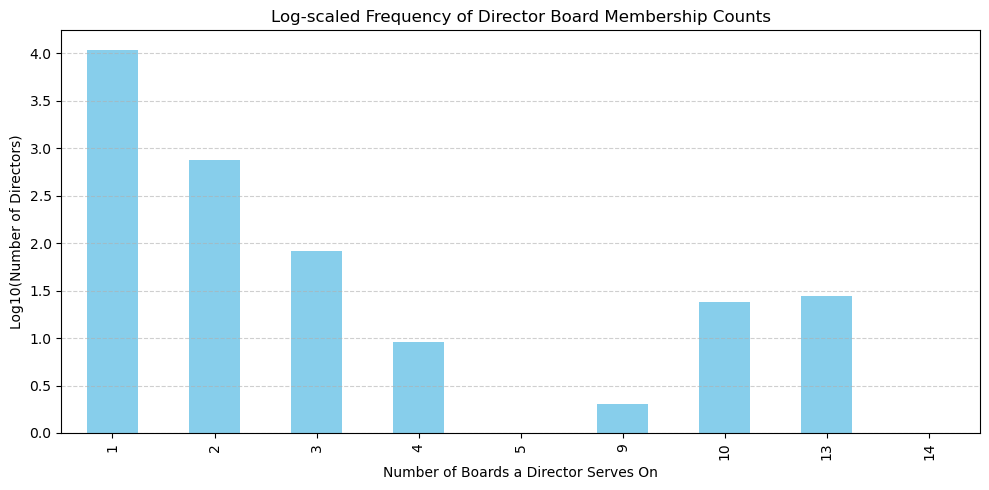

In [126]:
# counts number of companies director is on
directorship_counts = read_company_DS.groupby('director_name').company_name.nunique()

# distribution of directorship counts:
distribution = directorship_counts.value_counts().sort_index()
log_distribution = distribution.map(math.log10)

plt.figure(figsize=(10, 5))
log_distribution.plot(kind='bar', color='skyblue')
plt.title("Log-scaled Frequency of Director Board Membership Counts")
plt.xlabel("Number of Boards a Director Serves On")
plt.ylabel("Log10(Number of Directors)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Task 5a presentation.

Changes made:
    - Created a network showing which directors sit on which company boards
    - Used different measures to find the most important people in the network
    - Cleaned and worked with real-world company data from official filings

Who are the key people?
    We looked at three factors:
    - Degree: People who sit on the most boards
    - Eigenvector: People connected to other important people
    - Betweenness: People who link different groups together

The findings:
    - Most directors only sit on one or two boards
    - A few directors sit on many boards and have lots of connections
    - Directors with a tech background stood out more than the others

Possible improvements:
    - Add data like company value or industry (e.g., using ASX info)
    - See if certain industries have more connected directors
    - Compare director roles (like CEO vs CFO) to see if it affects their influence


In [129]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [131]:
people = []
companies = []
for company_name, director_name in zip(read_company_DS.company_name, read_company_DS.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [133]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

In [135]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
})
centrality['betweenness'] = pandas.Series(networkx.betweenness_centrality(biggest_connected_graph))
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 3min 25s, sys: 1.91 s, total: 3min 27s
Wall time: 3min 29s


We identified influential individuals in the company-director network using three centrality measures:

 - Degree centrality: A high degree indicates that a director serves on multiple boards and is well-connected.
 - Eigenvector centrality: A high eigenvector score indicates that they are related to other powerful individuals; these are prestige hubs.
 - Betweenness centrality (new): A high score indicates that a person connects several groups, which is beneficial for facilitating deals or acquisitions.

 This aids in discovering not only well-connected individuals, but also strategic links within the network, which aligns with our goal of identifying possible acquisition candidates.

In [137]:
people_read_company_DS = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [138]:
people_read_company_DS.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,1.394057e-07,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,1.394057e-07,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,0.000000e+00,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,70,50356,female,4.702060


In [139]:
read_company_DS[read_company_DS.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [140]:
import sklearn.cluster

In [141]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_read_company_DS[['age', 'log_compensation', 'degree', 'eigen']])


In [142]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_read_company_DS['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_read_company_DS.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

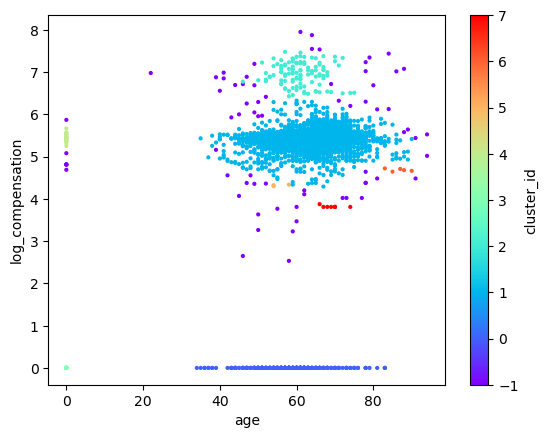

In [143]:
people_read_company_DS.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [144]:
people_read_company_DS.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

Task 5b: Ethics report

Who is impacted by this analysis?

This network analysis can impact Directors, whose influence is evaluated and ranked. Companies which may be targeted or avoided based on board structure. Investors who may act on this information, sometimes without full context.

Despite the fact that the data is public, involvement in this type of network may have an impact on a director's professional reputation or a company's strategic value.

Privacy & Consent

The data was obtained via public filings, but this does not eliminate all ethical concerns:
Directors did not necessarily consent to being analysed in this manner. Linking this to third-party data (such as market capitalisation or demographics) may unintentionally remove anonymity or profile individuals.

It's important to ensure that this type of data is used appropriately, rather than to unfairly criticise individuals or organisations based on insufficient metrics.

Risks of Misuse

There are various concerns if this type of analysis is used incorrectly. Over-reliance on centrality may lead investors to ignore valuable but less-connected persons or organisations. It may reinforce existing power structures, such as always choosing well-connected directors over diverse or independent ones.
If used to target takeovers, it may influence corporate strategy based on weak signifiers.

Use of generative AI:
AI was used to help structure written sections. for example in task 5b, It was difficult to structure the ethics report section, AI put the content in a format that was concise and structured in a suitable way for the task.